In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,LSTM,Dropout,Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words=stopwords.words('english')

In [ ]:
imdb_data=pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')

In [ ]:
def review_preprocessing():
    
    X = imdb_data['review']  
    X = X.replace({'<.*?>': ''}, regex = True )  
    X = X.replace({'[^A-Za-z]': ' '}, regex = True) 
    X = X.replace({'\s+':' '},regex=True)   
    X = X.apply(lambda review: [word for word in review.split() if word not in stop_words])  
    X = X.apply(lambda review: [word.lower() for word in review])  
    return X

X= review_preprocessing()
X

0        [one, reviewers, mentioned, watching, oz, epis...
1        [a, wonderful, little, production, the, filmin...
2        [i, thought, wonderful, way, spend, time, hot,...
3        [basically, family, little, boy, jake, thinks,...
4        [petter, mattei, love, time, money, visually, ...
                               ...                        
49995    [i, thought, movie, right, good, job, it, crea...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [i, catholic, taught, parochial, elementary, s...
49998    [i, going, disagree, previous, comment, side, ...
49999    [no, one, expects, star, trek, movies, high, a...
Name: review, Length: 50000, dtype: object

In [ ]:
y = imdb_data['sentiment']
y = y.replace('positive', 1)
y = y.replace('negative', 0)

In [ ]:
print('Maximum review length',len(max((X),key=len)))         
print('Minimum review length',len(min((X),key=len)))
review_length=[]
for i in X:
    review_length.append(len(i))
print('Average length of review',sum(review_length)/len(X))

Maximum review length 1481
Minimum review length 4
Average length of review 129.72056


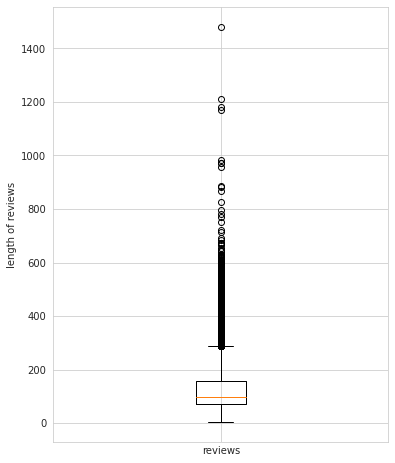

In [ ]:
review_length=np.array(review_length)
df=pd.DataFrame(review_length)
sns.set_style("whitegrid")
plt.figure(figsize=(6,8))
plt.boxplot(df[0])
plt.xlabel('reviews')
plt.ylabel('length of reviews')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

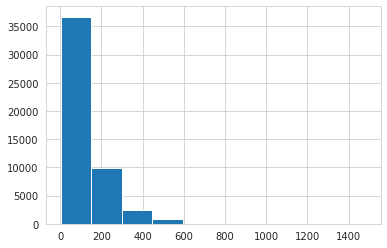

count    50000.000000
mean       129.720560
std         96.151423
min          4.000000
25%         71.000000
50%         97.000000
75%        158.000000
max       1481.000000
dtype: float64

In [ ]:
pd.Series(review_length).hist()
plt.show()
pd.Series(review_length).describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000,)
(40000,)
(10000,)
(10000,)


In [ ]:
token = Tokenizer(lower=False)    
token.fit_on_texts(X)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)
max_length=130
X_train = pad_sequences(X_train, maxlen=max_length, padding='post',truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post',truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding


In [ ]:
total_words

101398

In [ ]:
def create_model():
    model=None
    model=tf.keras.Sequential()
    model.add(Embedding(total_words,32,input_length=max_length))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 32)           3244736   
_________________________________________________________________
dropout (Dropout)            (None, 130, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 130, 100)          53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 130, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 3,307,637
Trainable params: 3,307,637
Non-trainable params: 0
______________________________________________

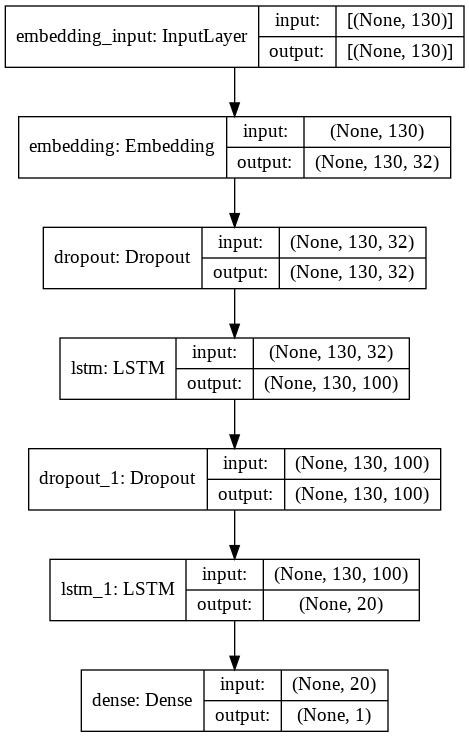

In [ ]:
plot_model(model,'model.png',show_shapes=True)

In [ ]:
filepath = "/content/drive/MyDrive/lstm_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',              
                                                 save_best_only=True,
                                                 mode='max',
                                                 verbose=1)
early_stop=EarlyStopping(monitor='val_accuracy',patience=5,verbose=1)                          
                                                 
callback_list=[checkpoint,early_stop]

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25,batch_size=64,callbacks=callback_list)

Epoch 1/25
625/625 [==============================] - 147s 230ms/step - loss: 0.6918 - accuracy: 0.5067 - val_loss: 0.6912 - val_accuracy: 0.5087

Epoch 00001: val_accuracy improved from -inf to 0.50870, saving model to /content/drive/MyDrive/lstm_models/weights-improvement-01-0.69.hdf5
Epoch 2/25
625/625 [==============================] - 141s 226ms/step - loss: 0.6932 - accuracy: 0.5123 - val_loss: 0.6932 - val_accuracy: 0.4987

Epoch 00002: val_accuracy did not improve from 0.50870
Epoch 3/25
625/625 [==============================] - 141s 226ms/step - loss: 0.6503 - accuracy: 0.6087 - val_loss: 0.5163 - val_accuracy: 0.7863

Epoch 00003: val_accuracy improved from 0.50870 to 0.78630, saving model to /content/drive/MyDrive/lstm_models/weights-improvement-03-0.52.hdf5
Epoch 4/25
625/625 [==============================] - 142s 227ms/step - loss: 0.3943 - accuracy: 0.8427 - val_loss: 0.4066 - val_accuracy: 0.8407

Epoch 00004: val_accuracy improved from 0.78630 to 0.84070, saving model

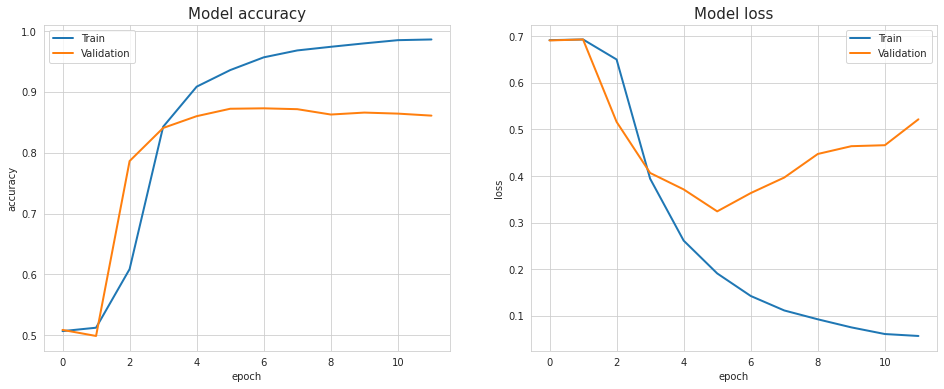

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=2)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axis1.set_title('Model accuracy', fontsize=15)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=2)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=2)
axis2.set_title('Model loss', fontsize=15)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
model=load_model('/content/drive/MyDrive/lstm_models/weights-improvement-07-0.36.hdf5')

In [ ]:

y_test_pred = model.predict_classes(X_test)

In [ ]:
accuracy_score(y_test,y_test_pred)

0.873

In [ ]:
def confusion_matrix_plot(y_test,y_test_pred):
    con_matrix=confusion_matrix(y_test,y_test_pred)
    ax= plt.subplot()
    sns.heatmap(con_matrix, annot=True, fmt='g', ax=ax)  
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['positive', 'negative'])
    ax.yaxis.set_ticklabels(['positive', 'negative'])

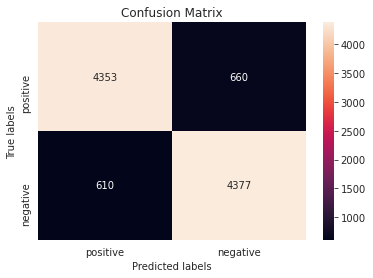

In [ ]:
confusion_matrix_plot(y_test,y_test_pred)

# **WORD2VEC Embedding**

In [1]:
import gensim
from nltk.tokenize import word_tokenize
from tensorflow.keras.initializers import Constant
nltk.download('punkt')

NameError: ignored

In [ ]:
reviews=imdb_data['review'].values.tolist()

In [ ]:
len(reviews)

In [ ]:
lst_review=[]
for review in reviews:
    review=review.lower()
    review=re.sub('<.*?>',"",review)
    review=re.sub('[^A-Za-z]'," ",review)
    review=re.sub('\s+',' ',review)
    review=[word for word in review.split(' ') if word not in stop_words]
    lst_review.append(review)




In [ ]:
w2vmodel=None
w2vmodel=gensim.models.Word2Vec(lst_review, size=300, window=5, min_count=3)

In [ ]:
words=list(w2vmodel.wv.vocab)
len(words)

In [ ]:
w2vmodel.train(lst_review,epochs=10,total_examples=len(lst_review))

In [ ]:
vocab=w2vmodel.wv.vocab
vocab=list(vocab.keys())

In [ ]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=w2vmodel.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

In [ ]:
token = Tokenizer(lower=False)    
token.fit_on_texts(X)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(X)
padded=pad_sequences(encoded, maxlen=130, padding='post', truncating='post')

In [ ]:
print(vocab_size)
print(padded.shape)

In [ ]:
embed_matrix=np.zeros(shape=(vocab_size,300))
for word,i in token.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  
    embed_matrix[i]=embed_vector

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)

In [ ]:
from tensorflow.keras.initializers import Constant

In [ ]:
def create_model():
    model=None
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size,output_dim=300,input_length=130,embeddings_initializer=Constant(embed_matrix)))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(20))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [ ]:
model=create_model()
model.summary()

In [ ]:
plot_model(model,'model.png',show_shapes=True)

In [ ]:
filepath = "/content/drive/MyDrive/lstmw2v_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',             
                                                 save_best_only=True,
                                                 mode='max',
                                                 verbose=1)
early_stop=EarlyStopping(monitor='val_accuracy',patience=5,verbose=1)                          
                                                 
callback_list=[checkpoint,early_stop]

In [ ]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25,batch_size=64,callbacks=callback_list)

In [ ]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=2)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axis1.set_title('Model accuracy', fontsize=15)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=2)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=2)
axis2.set_title('Model loss', fontsize=15)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
model=load_model('/content/drive/MyDrive/lstmw2v_models/weights-improvement-04-0.30.hdf5')

In [ ]:
y_test_pred = model.predict_classes(X_test)

In [ ]:
accuracy_score(y_test,y_test_pred)

In [ ]:
confusion_matrix_plot(y_test,y_test_pred)